
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [1]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/home/ubuntu/mmdet1024/input"


In [2]:
pwd

'/home/ubuntu/mmdet1024'

In [3]:
os.makedirs('./input', exist_ok=True)
os.makedirs('./output', exist_ok=True)
%cd input

/home/ubuntu/mmdet1024/input


In [4]:
cd /home/ubuntu/mmdet1024/input

/home/ubuntu/mmdet1024/input


In [5]:
df = pd.read_csv('./train.csv')
df1= df
df1

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


In [6]:
df1['x_min'] = df1['x_min'] / df1['width'] * 1024.0
df1['x_max'] = df1['x_max'] / df1['width'] * 1024.0
df1['y_min'] = df1['y_min'] / df1['height'] * 1024.0
df1['y_max'] = df1['y_max'] / df1['height'] * 1024.0
df1


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,340.184615,602.739726,813.784615,802.630137,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,561.777778,264.177778,716.000000,362.311111,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,401.170732,491.419608,874.146341,658.070588,1968,2040


In [7]:
df=df1

In [8]:
df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,340.184615,602.739726,813.784615,802.630137,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,561.777778,264.177778,716.000000,362.311111,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,401.170732,491.419608,874.146341,658.070588,1968,2040


In [9]:
# nofinding 제거!!
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

/tmp/ipykernel_5430/890666907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_id'] = df['class_id'] + 1


,image_id,class_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,4,340.184615,602.739726,813.784615,802.630137
3,051132a778e61a86eb147c7c6f564dfe,1,561.777778,264.177778,716.000000,362.311111
5,1c32170b4af4ce1a3030eb8167753b06,12,252.774803,119.000000,381.782677,144.333333
6,0c7a38f293d5f5e4846aa4ca6db4daf1,6,603.644639,98.191781,980.530416,869.297847
7,47ed17dcb2cbeec15182ed335a8b5a9e,9,222.105919,718.296451,269.158879,758.609007
...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,11,106.666667,551.111111,249.777778,711.466667
67906,26d1d5a0ef2e692c6340e74859ffdc53,14,387.666667,262.333333,446.000000,313.666667
67907,22672ab82c290c20b86863291e25ef6c,6,149.500000,271.974400,397.000000,617.676800
67908,db169d0be36123bd55b866d6aa73983b,10,2.666667,238.222222,120.888889,617.244444


In [10]:
df['class_id'].value_counts()

1     7162
4     5427
12    4842
14    4655
9     2580
8     2483
11    2476
10    2203
7     1247
6     1000
3      960
5      556
2      279
13     226
Name: class_id, dtype: int64

In [11]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    # images
    res['images'].append({
        'id': pic_name,
        'width': 1024,
        'height': 1024,
        'file_name': pic_name+".png"
    })
    
    # annotations
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
# categories    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [12]:
random.seed(10)

# train_files = glob(os.path.join(base_dir, 'train/*.png'))
# train_files = os.listdir('./input/train')
# train_files = list(map(del_extension, train_files))
train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [13]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [14]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [15]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [16]:
!pip show torch

Name: torch
Version: 1.10.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages
Requires: typing_extensions
Required-by: timm, torchaudio, torchvision


런타임 다시 시작하고 진행합니다.

In [17]:
%cd ../

/home/ubuntu/mmdet1024


In [18]:
!git clone https://github.com/open-mmlab/mmdetection.git

fatal: destination path 'mmdetection' already exists and is not an empty directory.


In [19]:
%cd ./mmdetection

/home/ubuntu/mmdet1024/mmdetection


=========

In [20]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0 True
2.25.2
11.3
GCC 9.3


In [21]:
pwd

'/home/ubuntu/mmdet1024/mmdetection'

In [22]:
# %cd mmdetection
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
#       -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

# %cd mmdetection
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/centernet/centernet_resnet18_140e_coco/centernet_resnet18_140e_coco_20210705_093630-bb5b3bf7.pth \ \
      -O /home/ubuntu/mmdet1024/mmdetection/checkpoints/centernet_resnet18_140e_coco_20210705_093630-bb5b3bf7.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-10-28 02:42:41--  https://download.openmmlab.com/mmdetection/v2.0/centernet/centernet_resnet18_140e_coco/centernet_resnet18_140e_coco_20210705_093630-bb5b3bf7.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.43
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.43|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2022-10-28 02:42:42--  http://%20/
Resolving   ( )... failed: Name or service not known.
wget: unable to resolve host address ‘ ’


In [23]:
# Choose to use a config and initialize the detector
config = "/home/ubuntu/mmdet1024/mmdetection/configs/centernet/centernet_resnet18_140e_coco.py"
# Setup a checkpoint file to load
checkpoint = '/home/ubuntu/mmdet1024/mmdetection/checkpoints/centernet_resnet18_140e_coco_20210705_093630-bb5b3bf7.pth'
# initialize the detector
#model = init_detector(config, checkpoint, device='cuda:0')

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [24]:
import mmcv
import matplotlib.pyplot as plt
import copy
import os.path as osp
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [25]:
from mmcv import Config
cfg = Config.fromfile(config)

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [26]:
from mmdet.apis import set_random_seed

base_path = '/home/ubuntu/mmdet1024/input' 
%cd '/home/ubuntu/mmdet1024/input'

/home/ubuntu/mmdet1024/input


In [27]:
save_dir = os.path.join(base_path, "work_dir")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_dir

'/home/ubuntu/mmdet1024/input/work_dir'

In [28]:
EPOCHS = 30
cfg.work_dir = save_dir+'/centernet/1'

val_anno = "valid_annotations.json"  
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"

# 이미지 폴더 설정
train_img = "train" # 출력은 "train_100000"
val_img = 'train'
test_img =  "test"


# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = val_anno
cfg.data.val.img_prefix = val_img

# test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img


cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis'
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
cfg.model.bbox_head['num_classes'] = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint # Error가 날 경우, "/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth"


"""
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.


#betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#cfg.optimizer.lr = 0.02 / 8
cfg.lr_config = dict(warmup_iters=1000, step=[8, 11])
"""
"""
cfg.optimizer = dict(
    type='AdamW',
    lr=0.0001,
    betas=(0.9, 0.999),
    weight_decay=0.05,
    paramwise_cfg=dict(
        custom_keys={
            'absolute_pos_embed': dict(decay_mult=0.),
            'relative_position_bias_table': dict(decay_mult=0.),
            'norm': dict(decay_mult=0.)
        }))
"""

cfg.optimizer = dict(type='Adam', lr=0.0003,weight_decay=0.0001)
cfg.lr_config.warmup = None


# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

# 10개씩 잘라서 학습.. 미니배치 느낌이랄까?
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
dataset_type = 'CocoDataset'
data_root = '/home/ubuntu/mmdet1024/input'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile', to_float32=True, color_type='color'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='PhotoMetricDistortion',
        brightness_delta=32,
        contrast_range=(0.5, 1.5),
        saturation_range=(0.5, 1.5),
        hue_delta=18),
    dict(
        type='RandomCenterCropPad',
        crop_size=(512, 512),
        ratios=(0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3),
        mean=[0, 0, 0],
        std=[1, 1, 1],
        to_rgb=True,
        test_pad_mode=None),
    dict(type='Resize', img_scale=(512, 512), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='DefaultFormatBundl

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [30]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1922  | 11 [Pleur

In [31]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-27 04:39:42,517 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-27 04:39:42,561 - mmdet - INFO - load checkpoint from local path: /home/ubuntu/mmdet1024/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth
2022-10-27 04:39:42,699 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([126, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([126]).
2022-10-27 04:39:42,709 - mmdet - INFO - Start running, host: ubuntu@ip-172-31-69-122, work_dir: /home/ubuntu/mmdet1024/input/work_dir/retina/1
2022-10-27 04:39:42,709 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-27 04:39:52,557 - mmdet - INFO - Epoch [1][10/440]	lr: 3.000e-04, eta: 3:36:20, time: 0.984, data_time: 0.247, memory: 10847, loss_cls: 353.5905, loss_bbox: 0.7830, loss: 354.3735
2022-10-27 04:39:59,259 - mmdet - INFO - Epoch [1][20/440]	lr: 3.000e-04, eta: 3:01:42, time: 0.670, data_time: 0.015, memory: 10847, loss_cls: 3.2220, loss_bbox: 0.6458, loss: 3.8678
2022-10-27 04:40:05,933 - mmdet - INFO - Epoch [1][30/440]	lr: 3.000e-04, eta: 2:49:52, time: 0.667, data_time: 0.014, memory: 10847, loss_cls: 1.4122, loss_bbox: 0.6497, loss: 2.0620
2022-10-27 04:40:12,595 - mmdet - INFO - Epoch [1][40/440]	lr: 3.000e-04, eta: 2:43:50, time: 0.666, data_time: 0.014, memory: 10848, loss_cls: 1.0999, loss_bbox: 0.6516, loss: 1.7515
2022-10-27 04:40:19,267 - mmdet - INFO - Epoch [1][50/440]	lr: 3.000e-04, eta: 2:40:12, time: 0.667, data_time: 0.014, memory: 10849, loss_cls: 0.9545, loss_bbox: 0.6182, loss: 1.5727
2022-10-27 04:40:25,955 - mmdet - INFO - Epoch [1][60/440]	lr: 3.000e-04, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.6 task/s, elapsed: 41s, ETA:     0s

2022-10-27 04:45:24,298 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.84s).
Accumulating evaluation results...


2022-10-27 04:45:30,067 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.38s).


2022-10-27 04:45:39,212 - mmdet - INFO - Epoch [2][10/440]	lr: 3.000e-04, eta: 2:25:07, time: 0.904, data_time: 0.247, memory: 10940, loss_cls: 0.6755, loss_bbox: 0.5648, loss: 1.2403
2022-10-27 04:45:45,900 - mmdet - INFO - Epoch [2][20/440]	lr: 3.000e-04, eta: 2:24:56, time: 0.669, data_time: 0.014, memory: 10940, loss_cls: 0.6910, loss_bbox: 0.5399, loss: 1.2309
2022-10-27 04:45:52,601 - mmdet - INFO - Epoch [2][30/440]	lr: 3.000e-04, eta: 2:24:46, time: 0.670, data_time: 0.016, memory: 10940, loss_cls: 0.6576, loss_bbox: 0.5437, loss: 1.2013
2022-10-27 04:45:59,293 - mmdet - INFO - Epoch [2][40/440]	lr: 3.000e-04, eta: 2:24:35, time: 0.669, data_time: 0.014, memory: 10940, loss_cls: 0.6520, loss_bbox: 0.5227, loss: 1.1747
2022-10-27 04:46:05,991 - mmdet - INFO - Epoch [2][50/440]	lr: 3.000e-04, eta: 2:24:25, time: 0.670, data_time: 0.015, memory: 10940, loss_cls: 0.6686, loss_bbox: 0.5368, loss: 1.2054
2022-10-27 04:46:12,695 - mmdet - INFO - Epoch [2][60/440]	lr: 3.000e-04, eta: 2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.3 task/s, elapsed: 41s, ETA:     0s

2022-10-27 04:51:11,238 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.99s).
Accumulating evaluation results...


2022-10-27 04:51:17,624 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.092
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.69s).


2022-10-27 04:51:26,844 - mmdet - INFO - Epoch [3][10/440]	lr: 3.000e-04, eta: 2:19:23, time: 0.910, data_time: 0.252, memory: 10940, loss_cls: 0.5310, loss_bbox: 0.4794, loss: 1.0104
2022-10-27 04:51:33,564 - mmdet - INFO - Epoch [3][20/440]	lr: 3.000e-04, eta: 2:19:15, time: 0.672, data_time: 0.016, memory: 10940, loss_cls: 0.5325, loss_bbox: 0.4858, loss: 1.0183
2022-10-27 04:51:40,289 - mmdet - INFO - Epoch [3][30/440]	lr: 3.000e-04, eta: 2:19:07, time: 0.673, data_time: 0.016, memory: 10948, loss_cls: 0.5238, loss_bbox: 0.4795, loss: 1.0033
2022-10-27 04:51:46,989 - mmdet - INFO - Epoch [3][40/440]	lr: 3.000e-04, eta: 2:18:59, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.5371, loss_bbox: 0.4726, loss: 1.0097
2022-10-27 04:51:53,688 - mmdet - INFO - Epoch [3][50/440]	lr: 3.000e-04, eta: 2:18:51, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.5077, loss_bbox: 0.4740, loss: 0.9817
2022-10-27 04:52:00,377 - mmdet - INFO - Epoch [3][60/440]	lr: 3.000e-04, eta: 2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.3 task/s, elapsed: 41s, ETA:     0s

2022-10-27 04:56:58,881 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.22s).
Accumulating evaluation results...


2022-10-27 04:57:05,634 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.130
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.81s).


2022-10-27 04:57:14,819 - mmdet - INFO - Epoch [4][10/440]	lr: 3.000e-04, eta: 2:14:10, time: 0.906, data_time: 0.249, memory: 10948, loss_cls: 0.5024, loss_bbox: 0.4616, loss: 0.9639
2022-10-27 04:57:21,522 - mmdet - INFO - Epoch [4][20/440]	lr: 3.000e-04, eta: 2:14:03, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.4991, loss_bbox: 0.4472, loss: 0.9463
2022-10-27 04:57:28,233 - mmdet - INFO - Epoch [4][30/440]	lr: 3.000e-04, eta: 2:13:55, time: 0.671, data_time: 0.016, memory: 10948, loss_cls: 0.4757, loss_bbox: 0.4589, loss: 0.9346
2022-10-27 04:57:34,953 - mmdet - INFO - Epoch [4][40/440]	lr: 3.000e-04, eta: 2:13:48, time: 0.672, data_time: 0.016, memory: 10948, loss_cls: 0.4933, loss_bbox: 0.4461, loss: 0.9395
2022-10-27 04:57:41,657 - mmdet - INFO - Epoch [4][50/440]	lr: 3.000e-04, eta: 2:13:40, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.4773, loss_bbox: 0.4483, loss: 0.9256
2022-10-27 04:57:48,365 - mmdet - INFO - Epoch [4][60/440]	lr: 3.000e-04, eta: 2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:02:46,555 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.32s).
Accumulating evaluation results...


2022-10-27 05:02:53,421 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.158
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.80s).


2022-10-27 05:03:02,630 - mmdet - INFO - Epoch [5][10/440]	lr: 3.000e-04, eta: 2:09:04, time: 0.907, data_time: 0.251, memory: 10948, loss_cls: 0.4632, loss_bbox: 0.4634, loss: 0.9265
2022-10-27 05:03:09,319 - mmdet - INFO - Epoch [5][20/440]	lr: 3.000e-04, eta: 2:08:57, time: 0.669, data_time: 0.015, memory: 10948, loss_cls: 0.4597, loss_bbox: 0.4237, loss: 0.8833
2022-10-27 05:03:16,016 - mmdet - INFO - Epoch [5][30/440]	lr: 3.000e-04, eta: 2:08:49, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.4587, loss_bbox: 0.4158, loss: 0.8745
2022-10-27 05:03:22,714 - mmdet - INFO - Epoch [5][40/440]	lr: 3.000e-04, eta: 2:08:42, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.4641, loss_bbox: 0.4461, loss: 0.9102
2022-10-27 05:03:29,414 - mmdet - INFO - Epoch [5][50/440]	lr: 3.000e-04, eta: 2:08:35, time: 0.670, data_time: 0.015, memory: 10948, loss_cls: 0.3971, loss_bbox: 0.3981, loss: 0.7952
2022-10-27 05:03:36,123 - mmdet - INFO - Epoch [5][60/440]	lr: 3.000e-04, eta: 2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.3 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:08:34,674 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.17s).
Accumulating evaluation results...


2022-10-27 05:08:41,517 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.182
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.76s).


2022-10-27 05:08:50,689 - mmdet - INFO - Epoch [6][10/440]	lr: 3.000e-04, eta: 2:04:03, time: 0.905, data_time: 0.250, memory: 10948, loss_cls: 0.4516, loss_bbox: 0.4220, loss: 0.8736
2022-10-27 05:08:57,375 - mmdet - INFO - Epoch [6][20/440]	lr: 3.000e-04, eta: 2:03:56, time: 0.669, data_time: 0.014, memory: 10948, loss_cls: 0.4316, loss_bbox: 0.4334, loss: 0.8650
2022-10-27 05:09:04,061 - mmdet - INFO - Epoch [6][30/440]	lr: 3.000e-04, eta: 2:03:49, time: 0.669, data_time: 0.015, memory: 10948, loss_cls: 0.4338, loss_bbox: 0.4319, loss: 0.8658
2022-10-27 05:09:10,764 - mmdet - INFO - Epoch [6][40/440]	lr: 3.000e-04, eta: 2:03:42, time: 0.670, data_time: 0.016, memory: 10948, loss_cls: 0.4093, loss_bbox: 0.4119, loss: 0.8212
2022-10-27 05:09:17,477 - mmdet - INFO - Epoch [6][50/440]	lr: 3.000e-04, eta: 2:03:34, time: 0.671, data_time: 0.016, memory: 10948, loss_cls: 0.4036, loss_bbox: 0.4309, loss: 0.8345
2022-10-27 05:09:24,178 - mmdet - INFO - Epoch [6][60/440]	lr: 3.000e-04, eta: 2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:14:22,063 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.27s).
Accumulating evaluation results...


2022-10-27 05:14:28,905 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.184
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.82s).


2022-10-27 05:14:38,111 - mmdet - INFO - Epoch [7][10/440]	lr: 3.000e-04, eta: 1:59:02, time: 0.907, data_time: 0.249, memory: 10948, loss_cls: 0.4208, loss_bbox: 0.4149, loss: 0.8357
2022-10-27 05:14:44,798 - mmdet - INFO - Epoch [7][20/440]	lr: 3.000e-04, eta: 1:58:55, time: 0.669, data_time: 0.014, memory: 10948, loss_cls: 0.3920, loss_bbox: 0.3950, loss: 0.7870
2022-10-27 05:14:51,475 - mmdet - INFO - Epoch [7][30/440]	lr: 3.000e-04, eta: 1:58:48, time: 0.668, data_time: 0.014, memory: 10948, loss_cls: 0.4120, loss_bbox: 0.4310, loss: 0.8430
2022-10-27 05:14:58,164 - mmdet - INFO - Epoch [7][40/440]	lr: 3.000e-04, eta: 1:58:41, time: 0.669, data_time: 0.014, memory: 10948, loss_cls: 0.4176, loss_bbox: 0.4119, loss: 0.8295
2022-10-27 05:15:04,858 - mmdet - INFO - Epoch [7][50/440]	lr: 3.000e-04, eta: 1:58:33, time: 0.669, data_time: 0.015, memory: 10948, loss_cls: 0.3834, loss_bbox: 0.4123, loss: 0.7958
2022-10-27 05:15:11,553 - mmdet - INFO - Epoch [7][60/440]	lr: 3.000e-04, eta: 1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:20:09,961 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.09s).
Accumulating evaluation results...


2022-10-27 05:20:16,527 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.186
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.76s).


2022-10-27 05:20:25,721 - mmdet - INFO - Epoch [8][10/440]	lr: 3.000e-04, eta: 1:54:02, time: 0.906, data_time: 0.250, memory: 10948, loss_cls: 0.3955, loss_bbox: 0.4093, loss: 0.8049
2022-10-27 05:20:32,398 - mmdet - INFO - Epoch [8][20/440]	lr: 3.000e-04, eta: 1:53:55, time: 0.668, data_time: 0.014, memory: 10948, loss_cls: 0.3622, loss_bbox: 0.3833, loss: 0.7455
2022-10-27 05:20:39,093 - mmdet - INFO - Epoch [8][30/440]	lr: 3.000e-04, eta: 1:53:48, time: 0.669, data_time: 0.015, memory: 10948, loss_cls: 0.3734, loss_bbox: 0.4106, loss: 0.7840
2022-10-27 05:20:45,803 - mmdet - INFO - Epoch [8][40/440]	lr: 3.000e-04, eta: 1:53:41, time: 0.671, data_time: 0.015, memory: 10948, loss_cls: 0.4040, loss_bbox: 0.4135, loss: 0.8175
2022-10-27 05:20:52,518 - mmdet - INFO - Epoch [8][50/440]	lr: 3.000e-04, eta: 1:53:34, time: 0.671, data_time: 0.015, memory: 10948, loss_cls: 0.3768, loss_bbox: 0.3975, loss: 0.7743
2022-10-27 05:20:59,214 - mmdet - INFO - Epoch [8][60/440]	lr: 3.000e-04, eta: 1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:25:57,888 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.03s).
Accumulating evaluation results...


2022-10-27 05:26:04,639 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.221
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.01s).


2022-10-27 05:26:13,840 - mmdet - INFO - Epoch [9][10/440]	lr: 3.000e-04, eta: 1:49:04, time: 0.908, data_time: 0.251, memory: 10955, loss_cls: 0.3863, loss_bbox: 0.3928, loss: 0.7790
2022-10-27 05:26:20,522 - mmdet - INFO - Epoch [9][20/440]	lr: 3.000e-04, eta: 1:48:57, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.4127, loss_bbox: 0.4000, loss: 0.8127
2022-10-27 05:26:27,227 - mmdet - INFO - Epoch [9][30/440]	lr: 3.000e-04, eta: 1:48:50, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.3354, loss_bbox: 0.3770, loss: 0.7124
2022-10-27 05:26:33,919 - mmdet - INFO - Epoch [9][40/440]	lr: 3.000e-04, eta: 1:48:43, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.3974, loss_bbox: 0.4158, loss: 0.8133
2022-10-27 05:26:40,601 - mmdet - INFO - Epoch [9][50/440]	lr: 3.000e-04, eta: 1:48:36, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.3729, loss_bbox: 0.3864, loss: 0.7594
2022-10-27 05:26:47,306 - mmdet - INFO - Epoch [9][60/440]	lr: 3.000e-04, eta: 1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:31:45,178 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.05s).
Accumulating evaluation results...


2022-10-27 05:31:51,755 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.227
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.79s).


2022-10-27 05:32:00,963 - mmdet - INFO - Epoch [10][10/440]	lr: 3.000e-04, eta: 1:44:05, time: 0.908, data_time: 0.251, memory: 10955, loss_cls: 0.3566, loss_bbox: 0.3933, loss: 0.7499
2022-10-27 05:32:07,652 - mmdet - INFO - Epoch [10][20/440]	lr: 3.000e-04, eta: 1:43:58, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.3607, loss_bbox: 0.3871, loss: 0.7478
2022-10-27 05:32:14,332 - mmdet - INFO - Epoch [10][30/440]	lr: 3.000e-04, eta: 1:43:51, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.3577, loss_bbox: 0.3951, loss: 0.7528
2022-10-27 05:32:21,016 - mmdet - INFO - Epoch [10][40/440]	lr: 3.000e-04, eta: 1:43:44, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.3740, loss_bbox: 0.3907, loss: 0.7647
2022-10-27 05:32:27,697 - mmdet - INFO - Epoch [10][50/440]	lr: 3.000e-04, eta: 1:43:37, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.3532, loss_bbox: 0.4001, loss: 0.7533
2022-10-27 05:32:34,381 - mmdet - INFO - Epoch [10][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.3 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:37:32,656 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.13s).
Accumulating evaluation results...


2022-10-27 05:37:39,298 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.219
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.78s).


2022-10-27 05:37:48,510 - mmdet - INFO - Epoch [11][10/440]	lr: 3.000e-04, eta: 1:39:06, time: 0.908, data_time: 0.250, memory: 10955, loss_cls: 0.3458, loss_bbox: 0.3775, loss: 0.7233
2022-10-27 05:37:55,204 - mmdet - INFO - Epoch [11][20/440]	lr: 3.000e-04, eta: 1:38:59, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.3266, loss_bbox: 0.3704, loss: 0.6970
2022-10-27 05:38:01,908 - mmdet - INFO - Epoch [11][30/440]	lr: 3.000e-04, eta: 1:38:52, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.3551, loss_bbox: 0.3704, loss: 0.7255
2022-10-27 05:38:08,617 - mmdet - INFO - Epoch [11][40/440]	lr: 3.000e-04, eta: 1:38:45, time: 0.671, data_time: 0.016, memory: 10955, loss_cls: 0.3434, loss_bbox: 0.3816, loss: 0.7250
2022-10-27 05:38:15,321 - mmdet - INFO - Epoch [11][50/440]	lr: 3.000e-04, eta: 1:38:38, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.3837, loss_bbox: 0.4076, loss: 0.7913
2022-10-27 05:38:22,018 - mmdet - INFO - Epoch [11][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:43:20,615 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.33s).
Accumulating evaluation results...


2022-10-27 05:43:27,657 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.214
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.82s).


2022-10-27 05:43:36,855 - mmdet - INFO - Epoch [12][10/440]	lr: 3.000e-04, eta: 1:34:08, time: 0.907, data_time: 0.251, memory: 10955, loss_cls: 0.3721, loss_bbox: 0.3819, loss: 0.7540
2022-10-27 05:43:43,538 - mmdet - INFO - Epoch [12][20/440]	lr: 3.000e-04, eta: 1:34:01, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.3584, loss_bbox: 0.3841, loss: 0.7426
2022-10-27 05:43:50,234 - mmdet - INFO - Epoch [12][30/440]	lr: 3.000e-04, eta: 1:33:54, time: 0.670, data_time: 0.016, memory: 10955, loss_cls: 0.3234, loss_bbox: 0.3548, loss: 0.6782
2022-10-27 05:43:56,926 - mmdet - INFO - Epoch [12][40/440]	lr: 3.000e-04, eta: 1:33:47, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.3409, loss_bbox: 0.3835, loss: 0.7244
2022-10-27 05:44:03,630 - mmdet - INFO - Epoch [12][50/440]	lr: 3.000e-04, eta: 1:33:41, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.3537, loss_bbox: 0.3761, loss: 0.7298
2022-10-27 05:44:10,321 - mmdet - INFO - Epoch [12][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.3 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:49:08,888 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.30s).
Accumulating evaluation results...


2022-10-27 05:49:15,690 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.237
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.79s).


2022-10-27 05:49:24,917 - mmdet - INFO - Epoch [13][10/440]	lr: 3.000e-04, eta: 1:29:10, time: 0.909, data_time: 0.252, memory: 10955, loss_cls: 0.3089, loss_bbox: 0.3626, loss: 0.6716
2022-10-27 05:49:31,617 - mmdet - INFO - Epoch [13][20/440]	lr: 3.000e-04, eta: 1:29:04, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.3511, loss_bbox: 0.3805, loss: 0.7316
2022-10-27 05:49:38,332 - mmdet - INFO - Epoch [13][30/440]	lr: 3.000e-04, eta: 1:28:57, time: 0.672, data_time: 0.015, memory: 10955, loss_cls: 0.3693, loss_bbox: 0.3896, loss: 0.7589
2022-10-27 05:49:45,041 - mmdet - INFO - Epoch [13][40/440]	lr: 3.000e-04, eta: 1:28:50, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.2995, loss_bbox: 0.3543, loss: 0.6538
2022-10-27 05:49:51,748 - mmdet - INFO - Epoch [13][50/440]	lr: 3.000e-04, eta: 1:28:43, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.3521, loss_bbox: 0.3748, loss: 0.7269
2022-10-27 05:49:58,465 - mmdet - INFO - Epoch [13][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 05:54:57,393 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.13s).
Accumulating evaluation results...


2022-10-27 05:55:03,974 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.247
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.74s).


2022-10-27 05:55:13,148 - mmdet - INFO - Epoch [14][10/440]	lr: 3.000e-04, eta: 1:24:13, time: 0.905, data_time: 0.249, memory: 10955, loss_cls: 0.3157, loss_bbox: 0.3538, loss: 0.6695
2022-10-27 05:55:19,841 - mmdet - INFO - Epoch [14][20/440]	lr: 3.000e-04, eta: 1:24:06, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.3417, loss_bbox: 0.3812, loss: 0.7228
2022-10-27 05:55:26,558 - mmdet - INFO - Epoch [14][30/440]	lr: 3.000e-04, eta: 1:23:59, time: 0.672, data_time: 0.016, memory: 10955, loss_cls: 0.3299, loss_bbox: 0.3823, loss: 0.7122
2022-10-27 05:55:33,278 - mmdet - INFO - Epoch [14][40/440]	lr: 3.000e-04, eta: 1:23:53, time: 0.672, data_time: 0.016, memory: 10955, loss_cls: 0.3292, loss_bbox: 0.3517, loss: 0.6808
2022-10-27 05:55:39,979 - mmdet - INFO - Epoch [14][50/440]	lr: 3.000e-04, eta: 1:23:46, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.3270, loss_bbox: 0.3566, loss: 0.6836
2022-10-27 05:55:46,698 - mmdet - INFO - Epoch [14][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:00:44,968 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.78s).
Accumulating evaluation results...


2022-10-27 06:00:51,451 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.241
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.97s).


2022-10-27 06:01:00,650 - mmdet - INFO - Epoch [15][10/440]	lr: 3.000e-04, eta: 1:19:15, time: 0.908, data_time: 0.252, memory: 10955, loss_cls: 0.3203, loss_bbox: 0.3585, loss: 0.6788
2022-10-27 06:01:07,348 - mmdet - INFO - Epoch [15][20/440]	lr: 3.000e-04, eta: 1:19:08, time: 0.670, data_time: 0.016, memory: 10955, loss_cls: 0.3289, loss_bbox: 0.3579, loss: 0.6869
2022-10-27 06:01:14,054 - mmdet - INFO - Epoch [15][30/440]	lr: 3.000e-04, eta: 1:19:01, time: 0.671, data_time: 0.016, memory: 10955, loss_cls: 0.3110, loss_bbox: 0.3598, loss: 0.6709
2022-10-27 06:01:20,748 - mmdet - INFO - Epoch [15][40/440]	lr: 3.000e-04, eta: 1:18:54, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.3033, loss_bbox: 0.3491, loss: 0.6523
2022-10-27 06:01:27,442 - mmdet - INFO - Epoch [15][50/440]	lr: 3.000e-04, eta: 1:18:48, time: 0.669, data_time: 0.016, memory: 10955, loss_cls: 0.3123, loss_bbox: 0.3585, loss: 0.6708
2022-10-27 06:01:34,132 - mmdet - INFO - Epoch [15][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:06:32,078 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.12s).
Accumulating evaluation results...


2022-10-27 06:06:38,655 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.245
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.75s).


2022-10-27 06:06:47,838 - mmdet - INFO - Epoch [16][10/440]	lr: 3.000e-04, eta: 1:14:17, time: 0.906, data_time: 0.248, memory: 10955, loss_cls: 0.3287, loss_bbox: 0.3576, loss: 0.6863
2022-10-27 06:06:54,515 - mmdet - INFO - Epoch [16][20/440]	lr: 3.000e-04, eta: 1:14:10, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.3112, loss_bbox: 0.3646, loss: 0.6759
2022-10-27 06:07:01,201 - mmdet - INFO - Epoch [16][30/440]	lr: 3.000e-04, eta: 1:14:03, time: 0.669, data_time: 0.014, memory: 10955, loss_cls: 0.3223, loss_bbox: 0.3661, loss: 0.6885
2022-10-27 06:07:07,873 - mmdet - INFO - Epoch [16][40/440]	lr: 3.000e-04, eta: 1:13:56, time: 0.667, data_time: 0.014, memory: 10955, loss_cls: 0.3102, loss_bbox: 0.3566, loss: 0.6668
2022-10-27 06:07:14,554 - mmdet - INFO - Epoch [16][50/440]	lr: 3.000e-04, eta: 1:13:49, time: 0.668, data_time: 0.015, memory: 10955, loss_cls: 0.3396, loss_bbox: 0.3757, loss: 0.7153
2022-10-27 06:07:21,252 - mmdet - INFO - Epoch [16][60/440]	lr: 3.000e-04, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:12:19,431 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.20s).
Accumulating evaluation results...


2022-10-27 06:12:26,123 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.246
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.78s).


2022-10-27 06:12:35,320 - mmdet - INFO - Epoch [17][10/440]	lr: 3.000e-05, eta: 1:09:19, time: 0.907, data_time: 0.248, memory: 10955, loss_cls: 0.3035, loss_bbox: 0.3453, loss: 0.6488
2022-10-27 06:12:42,029 - mmdet - INFO - Epoch [17][20/440]	lr: 3.000e-05, eta: 1:09:12, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.3016, loss_bbox: 0.3493, loss: 0.6509
2022-10-27 06:12:48,729 - mmdet - INFO - Epoch [17][30/440]	lr: 3.000e-05, eta: 1:09:05, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.2890, loss_bbox: 0.3672, loss: 0.6561
2022-10-27 06:12:55,419 - mmdet - INFO - Epoch [17][40/440]	lr: 3.000e-05, eta: 1:08:58, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.2883, loss_bbox: 0.3382, loss: 0.6264
2022-10-27 06:13:02,119 - mmdet - INFO - Epoch [17][50/440]	lr: 3.000e-05, eta: 1:08:52, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.2695, loss_bbox: 0.3428, loss: 0.6123
2022-10-27 06:13:08,819 - mmdet - INFO - Epoch [17][60/440]	lr: 3.000e-05, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:18:07,069 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.23s).
Accumulating evaluation results...


2022-10-27 06:18:13,780 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.78s).


2022-10-27 06:18:22,981 - mmdet - INFO - Epoch [18][10/440]	lr: 3.000e-05, eta: 1:04:21, time: 0.907, data_time: 0.250, memory: 10955, loss_cls: 0.2716, loss_bbox: 0.3419, loss: 0.6135
2022-10-27 06:18:29,704 - mmdet - INFO - Epoch [18][20/440]	lr: 3.000e-05, eta: 1:04:14, time: 0.672, data_time: 0.015, memory: 10955, loss_cls: 0.2633, loss_bbox: 0.3329, loss: 0.5962
2022-10-27 06:18:36,382 - mmdet - INFO - Epoch [18][30/440]	lr: 3.000e-05, eta: 1:04:08, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.2659, loss_bbox: 0.3327, loss: 0.5986
2022-10-27 06:18:43,063 - mmdet - INFO - Epoch [18][40/440]	lr: 3.000e-05, eta: 1:04:01, time: 0.668, data_time: 0.015, memory: 10955, loss_cls: 0.2377, loss_bbox: 0.3162, loss: 0.5538
2022-10-27 06:18:49,752 - mmdet - INFO - Epoch [18][50/440]	lr: 3.000e-05, eta: 1:03:54, time: 0.669, data_time: 0.014, memory: 10955, loss_cls: 0.2747, loss_bbox: 0.3383, loss: 0.6130
2022-10-27 06:18:56,451 - mmdet - INFO - Epoch [18][60/440]	lr: 3.000e-05, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:23:54,612 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.07s).
Accumulating evaluation results...


2022-10-27 06:24:01,080 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.70s).


2022-10-27 06:24:10,250 - mmdet - INFO - Epoch [19][10/440]	lr: 3.000e-05, eta: 0:59:24, time: 0.904, data_time: 0.248, memory: 10955, loss_cls: 0.2494, loss_bbox: 0.3166, loss: 0.5660
2022-10-27 06:24:16,945 - mmdet - INFO - Epoch [19][20/440]	lr: 3.000e-05, eta: 0:59:17, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.2581, loss_bbox: 0.3318, loss: 0.5898
2022-10-27 06:24:23,628 - mmdet - INFO - Epoch [19][30/440]	lr: 3.000e-05, eta: 0:59:10, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.2326, loss_bbox: 0.3144, loss: 0.5471
2022-10-27 06:24:30,318 - mmdet - INFO - Epoch [19][40/440]	lr: 3.000e-05, eta: 0:59:03, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.2338, loss_bbox: 0.3109, loss: 0.5447
2022-10-27 06:24:37,023 - mmdet - INFO - Epoch [19][50/440]	lr: 3.000e-05, eta: 0:58:56, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.2561, loss_bbox: 0.3294, loss: 0.5855
2022-10-27 06:24:43,732 - mmdet - INFO - Epoch [19][60/440]	lr: 3.000e-05, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:29:41,942 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.18s).
Accumulating evaluation results...


2022-10-27 06:29:48,522 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.71s).


2022-10-27 06:29:57,714 - mmdet - INFO - Epoch [20][10/440]	lr: 3.000e-05, eta: 0:54:26, time: 0.907, data_time: 0.250, memory: 10955, loss_cls: 0.2297, loss_bbox: 0.2986, loss: 0.5283
2022-10-27 06:30:04,407 - mmdet - INFO - Epoch [20][20/440]	lr: 3.000e-05, eta: 0:54:19, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.2343, loss_bbox: 0.3010, loss: 0.5352
2022-10-27 06:30:11,108 - mmdet - INFO - Epoch [20][30/440]	lr: 3.000e-05, eta: 0:54:12, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.2343, loss_bbox: 0.3233, loss: 0.5576
2022-10-27 06:30:17,810 - mmdet - INFO - Epoch [20][40/440]	lr: 3.000e-05, eta: 0:54:06, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.2284, loss_bbox: 0.3148, loss: 0.5431
2022-10-27 06:30:24,495 - mmdet - INFO - Epoch [20][50/440]	lr: 3.000e-05, eta: 0:53:59, time: 0.668, data_time: 0.015, memory: 10955, loss_cls: 0.2282, loss_bbox: 0.3000, loss: 0.5282
2022-10-27 06:30:31,203 - mmdet - INFO - Epoch [20][60/440]	lr: 3.000e-05, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:35:29,420 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.14s).
Accumulating evaluation results...


2022-10-27 06:35:36,110 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.286
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.69s).


2022-10-27 06:35:45,318 - mmdet - INFO - Epoch [21][10/440]	lr: 3.000e-05, eta: 0:49:28, time: 0.908, data_time: 0.252, memory: 10955, loss_cls: 0.2432, loss_bbox: 0.3044, loss: 0.5477
2022-10-27 06:35:52,020 - mmdet - INFO - Epoch [21][20/440]	lr: 3.000e-05, eta: 0:49:22, time: 0.670, data_time: 0.016, memory: 10955, loss_cls: 0.2345, loss_bbox: 0.3153, loss: 0.5498
2022-10-27 06:35:58,718 - mmdet - INFO - Epoch [21][30/440]	lr: 3.000e-05, eta: 0:49:15, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.1898, loss_bbox: 0.2880, loss: 0.4779
2022-10-27 06:36:05,404 - mmdet - INFO - Epoch [21][40/440]	lr: 3.000e-05, eta: 0:49:08, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.2002, loss_bbox: 0.2931, loss: 0.4933
2022-10-27 06:36:12,113 - mmdet - INFO - Epoch [21][50/440]	lr: 3.000e-05, eta: 0:49:01, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.2268, loss_bbox: 0.3020, loss: 0.5288
2022-10-27 06:36:18,823 - mmdet - INFO - Epoch [21][60/440]	lr: 3.000e-05, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:41:17,521 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.09s).
Accumulating evaluation results...


2022-10-27 06:41:24,118 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.79s).


2022-10-27 06:41:33,317 - mmdet - INFO - Epoch [22][10/440]	lr: 3.000e-05, eta: 0:44:31, time: 0.907, data_time: 0.249, memory: 10955, loss_cls: 0.2118, loss_bbox: 0.2936, loss: 0.5054
2022-10-27 06:41:40,011 - mmdet - INFO - Epoch [22][20/440]	lr: 3.000e-05, eta: 0:44:24, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.2189, loss_bbox: 0.2971, loss: 0.5160
2022-10-27 06:41:46,713 - mmdet - INFO - Epoch [22][30/440]	lr: 3.000e-05, eta: 0:44:17, time: 0.670, data_time: 0.014, memory: 10955, loss_cls: 0.2072, loss_bbox: 0.2934, loss: 0.5006
2022-10-27 06:41:53,419 - mmdet - INFO - Epoch [22][40/440]	lr: 3.000e-05, eta: 0:44:11, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.2052, loss_bbox: 0.2914, loss: 0.4967
2022-10-27 06:42:00,125 - mmdet - INFO - Epoch [22][50/440]	lr: 3.000e-05, eta: 0:44:04, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.2235, loss_bbox: 0.3023, loss: 0.5258
2022-10-27 06:42:06,848 - mmdet - INFO - Epoch [22][60/440]	lr: 3.000e-05, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:47:05,343 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.11s).
Accumulating evaluation results...


2022-10-27 06:47:11,848 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.278
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.69s).


2022-10-27 06:47:21,042 - mmdet - INFO - Epoch [23][10/440]	lr: 3.000e-06, eta: 0:39:33, time: 0.907, data_time: 0.249, memory: 10955, loss_cls: 0.1966, loss_bbox: 0.2847, loss: 0.4813
2022-10-27 06:47:27,733 - mmdet - INFO - Epoch [23][20/440]	lr: 3.000e-06, eta: 0:39:27, time: 0.669, data_time: 0.014, memory: 10955, loss_cls: 0.2074, loss_bbox: 0.2895, loss: 0.4969
2022-10-27 06:47:34,420 - mmdet - INFO - Epoch [23][30/440]	lr: 3.000e-06, eta: 0:39:20, time: 0.669, data_time: 0.014, memory: 10955, loss_cls: 0.1945, loss_bbox: 0.2775, loss: 0.4719
2022-10-27 06:47:41,098 - mmdet - INFO - Epoch [23][40/440]	lr: 3.000e-06, eta: 0:39:13, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.2042, loss_bbox: 0.2845, loss: 0.4887
2022-10-27 06:47:47,781 - mmdet - INFO - Epoch [23][50/440]	lr: 3.000e-06, eta: 0:39:06, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.1795, loss_bbox: 0.2791, loss: 0.4586
2022-10-27 06:47:54,477 - mmdet - INFO - Epoch [23][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:52:52,695 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.04s).
Accumulating evaluation results...


2022-10-27 06:52:59,067 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.285
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.64s).


2022-10-27 06:53:08,250 - mmdet - INFO - Epoch [24][10/440]	lr: 3.000e-06, eta: 0:34:36, time: 0.906, data_time: 0.249, memory: 10955, loss_cls: 0.1914, loss_bbox: 0.2890, loss: 0.4804
2022-10-27 06:53:14,945 - mmdet - INFO - Epoch [24][20/440]	lr: 3.000e-06, eta: 0:34:29, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.1761, loss_bbox: 0.2786, loss: 0.4547
2022-10-27 06:53:21,633 - mmdet - INFO - Epoch [24][30/440]	lr: 3.000e-06, eta: 0:34:22, time: 0.669, data_time: 0.016, memory: 10955, loss_cls: 0.1808, loss_bbox: 0.2685, loss: 0.4493
2022-10-27 06:53:28,339 - mmdet - INFO - Epoch [24][40/440]	lr: 3.000e-06, eta: 0:34:16, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.1977, loss_bbox: 0.2887, loss: 0.4863
2022-10-27 06:53:35,054 - mmdet - INFO - Epoch [24][50/440]	lr: 3.000e-06, eta: 0:34:09, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.1802, loss_bbox: 0.2668, loss: 0.4470
2022-10-27 06:53:41,760 - mmdet - INFO - Epoch [24][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 06:58:39,996 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.02s).
Accumulating evaluation results...


2022-10-27 06:58:46,339 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.285
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.195
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.64s).


2022-10-27 06:58:55,498 - mmdet - INFO - Epoch [25][10/440]	lr: 3.000e-06, eta: 0:29:38, time: 0.904, data_time: 0.248, memory: 10955, loss_cls: 0.2105, loss_bbox: 0.2838, loss: 0.4943
2022-10-27 06:59:02,216 - mmdet - INFO - Epoch [25][20/440]	lr: 3.000e-06, eta: 0:29:31, time: 0.672, data_time: 0.016, memory: 10955, loss_cls: 0.2123, loss_bbox: 0.2994, loss: 0.5116
2022-10-27 06:59:08,910 - mmdet - INFO - Epoch [25][30/440]	lr: 3.000e-06, eta: 0:29:25, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.1837, loss_bbox: 0.2738, loss: 0.4575
2022-10-27 06:59:15,619 - mmdet - INFO - Epoch [25][40/440]	lr: 3.000e-06, eta: 0:29:18, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.1920, loss_bbox: 0.2805, loss: 0.4725
2022-10-27 06:59:22,339 - mmdet - INFO - Epoch [25][50/440]	lr: 3.000e-06, eta: 0:29:11, time: 0.672, data_time: 0.016, memory: 10955, loss_cls: 0.1855, loss_bbox: 0.2788, loss: 0.4643
2022-10-27 06:59:29,045 - mmdet - INFO - Epoch [25][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.4 task/s, elapsed: 41s, ETA:     0s

2022-10-27 07:04:27,493 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.04s).
Accumulating evaluation results...


2022-10-27 07:04:33,884 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.66s).


2022-10-27 07:04:43,090 - mmdet - INFO - Epoch [26][10/440]	lr: 3.000e-06, eta: 0:24:41, time: 0.908, data_time: 0.252, memory: 10955, loss_cls: 0.1856, loss_bbox: 0.2830, loss: 0.4687
2022-10-27 07:04:49,775 - mmdet - INFO - Epoch [26][20/440]	lr: 3.000e-06, eta: 0:24:34, time: 0.669, data_time: 0.014, memory: 10955, loss_cls: 0.1831, loss_bbox: 0.2752, loss: 0.4583
2022-10-27 07:04:56,478 - mmdet - INFO - Epoch [26][30/440]	lr: 3.000e-06, eta: 0:24:27, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.1795, loss_bbox: 0.2620, loss: 0.4416
2022-10-27 07:05:03,207 - mmdet - INFO - Epoch [26][40/440]	lr: 3.000e-06, eta: 0:24:20, time: 0.673, data_time: 0.017, memory: 10955, loss_cls: 0.1987, loss_bbox: 0.2771, loss: 0.4758
2022-10-27 07:05:09,898 - mmdet - INFO - Epoch [26][50/440]	lr: 3.000e-06, eta: 0:24:14, time: 0.669, data_time: 0.016, memory: 10955, loss_cls: 0.1904, loss_bbox: 0.2739, loss: 0.4642
2022-10-27 07:05:16,604 - mmdet - INFO - Epoch [26][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 07:10:14,781 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.04s).
Accumulating evaluation results...


2022-10-27 07:10:21,209 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.69s).


2022-10-27 07:10:30,419 - mmdet - INFO - Epoch [27][10/440]	lr: 3.000e-06, eta: 0:19:43, time: 0.909, data_time: 0.250, memory: 10955, loss_cls: 0.1712, loss_bbox: 0.2709, loss: 0.4421
2022-10-27 07:10:37,118 - mmdet - INFO - Epoch [27][20/440]	lr: 3.000e-06, eta: 0:19:36, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.1674, loss_bbox: 0.2749, loss: 0.4423
2022-10-27 07:10:43,806 - mmdet - INFO - Epoch [27][30/440]	lr: 3.000e-06, eta: 0:19:30, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.1946, loss_bbox: 0.2866, loss: 0.4812
2022-10-27 07:10:50,513 - mmdet - INFO - Epoch [27][40/440]	lr: 3.000e-06, eta: 0:19:23, time: 0.671, data_time: 0.015, memory: 10955, loss_cls: 0.1583, loss_bbox: 0.2613, loss: 0.4197
2022-10-27 07:10:57,206 - mmdet - INFO - Epoch [27][50/440]	lr: 3.000e-06, eta: 0:19:16, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.1863, loss_bbox: 0.2756, loss: 0.4618
2022-10-27 07:11:03,912 - mmdet - INFO - Epoch [27][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.5 task/s, elapsed: 41s, ETA:     0s

2022-10-27 07:16:02,004 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.03s).
Accumulating evaluation results...


2022-10-27 07:16:08,341 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.64s).


2022-10-27 07:16:17,522 - mmdet - INFO - Epoch [28][10/440]	lr: 3.000e-06, eta: 0:14:45, time: 0.906, data_time: 0.249, memory: 10955, loss_cls: 0.1722, loss_bbox: 0.2699, loss: 0.4422
2022-10-27 07:16:24,220 - mmdet - INFO - Epoch [28][20/440]	lr: 3.000e-06, eta: 0:14:39, time: 0.670, data_time: 0.014, memory: 10955, loss_cls: 0.1717, loss_bbox: 0.2675, loss: 0.4392
2022-10-27 07:16:30,906 - mmdet - INFO - Epoch [28][30/440]	lr: 3.000e-06, eta: 0:14:32, time: 0.669, data_time: 0.014, memory: 10955, loss_cls: 0.1822, loss_bbox: 0.2724, loss: 0.4546
2022-10-27 07:16:37,602 - mmdet - INFO - Epoch [28][40/440]	lr: 3.000e-06, eta: 0:14:25, time: 0.670, data_time: 0.015, memory: 10955, loss_cls: 0.1898, loss_bbox: 0.2854, loss: 0.4752
2022-10-27 07:16:44,305 - mmdet - INFO - Epoch [28][50/440]	lr: 3.000e-06, eta: 0:14:18, time: 0.670, data_time: 0.016, memory: 10955, loss_cls: 0.1788, loss_bbox: 0.2663, loss: 0.4452
2022-10-27 07:16:51,015 - mmdet - INFO - Epoch [28][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.7 task/s, elapsed: 40s, ETA:     0s

2022-10-27 07:21:48,169 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.95s).
Accumulating evaluation results...


2022-10-27 07:21:54,345 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.54s).


2022-10-27 07:22:03,525 - mmdet - INFO - Epoch [29][10/440]	lr: 3.000e-06, eta: 0:09:48, time: 0.907, data_time: 0.249, memory: 10955, loss_cls: 0.1877, loss_bbox: 0.2749, loss: 0.4626
2022-10-27 07:22:10,193 - mmdet - INFO - Epoch [29][20/440]	lr: 3.000e-06, eta: 0:09:41, time: 0.667, data_time: 0.015, memory: 10955, loss_cls: 0.1565, loss_bbox: 0.2532, loss: 0.4098
2022-10-27 07:22:16,881 - mmdet - INFO - Epoch [29][30/440]	lr: 3.000e-06, eta: 0:09:34, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.1710, loss_bbox: 0.2708, loss: 0.4418
2022-10-27 07:22:23,553 - mmdet - INFO - Epoch [29][40/440]	lr: 3.000e-06, eta: 0:09:28, time: 0.667, data_time: 0.014, memory: 10955, loss_cls: 0.1915, loss_bbox: 0.2755, loss: 0.4670
2022-10-27 07:22:30,242 - mmdet - INFO - Epoch [29][50/440]	lr: 3.000e-06, eta: 0:09:21, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.1792, loss_bbox: 0.2741, loss: 0.4534
2022-10-27 07:22:36,929 - mmdet - INFO - Epoch [29][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.8 task/s, elapsed: 40s, ETA:     0s

2022-10-27 07:27:33,841 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.95s).
Accumulating evaluation results...


2022-10-27 07:27:40,006 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.53s).


2022-10-27 07:27:49,176 - mmdet - INFO - Epoch [30][10/440]	lr: 3.000e-06, eta: 0:04:50, time: 0.905, data_time: 0.249, memory: 10955, loss_cls: 0.1706, loss_bbox: 0.2760, loss: 0.4466
2022-10-27 07:27:55,851 - mmdet - INFO - Epoch [30][20/440]	lr: 3.000e-06, eta: 0:04:44, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.1829, loss_bbox: 0.2653, loss: 0.4482
2022-10-27 07:28:02,526 - mmdet - INFO - Epoch [30][30/440]	lr: 3.000e-06, eta: 0:04:37, time: 0.667, data_time: 0.014, memory: 10955, loss_cls: 0.1684, loss_bbox: 0.2760, loss: 0.4444
2022-10-27 07:28:09,205 - mmdet - INFO - Epoch [30][40/440]	lr: 3.000e-06, eta: 0:04:30, time: 0.668, data_time: 0.014, memory: 10955, loss_cls: 0.1813, loss_bbox: 0.2649, loss: 0.4462
2022-10-27 07:28:15,898 - mmdet - INFO - Epoch [30][50/440]	lr: 3.000e-06, eta: 0:04:23, time: 0.669, data_time: 0.015, memory: 10955, loss_cls: 0.1736, loss_bbox: 0.2651, loss: 0.4387
2022-10-27 07:28:22,572 - mmdet - INFO - Epoch [30][60/440]	lr: 3.000e-06, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 21.8 task/s, elapsed: 40s, ETA:     0s

2022-10-27 07:33:19,122 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.93s).
Accumulating evaluation results...


2022-10-27 07:33:25,280 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.279
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.57s).


In [32]:
PATH=f'/home/ubuntu/mmdet1024/output/model_retina/epoch_{EPOCHS}_retina_1.pt'
torch.save(model, PATH)

# 학습이어서

In [29]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/home/ubuntu/mmdet1024/input/work_dir/centernet/1/latest.pth'
cfg.load_from = None
EPOCHS = 140
# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)


In [30]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1922  | 11 [Pleur

2022-10-28 02:45:26,732 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-28 02:45:26,765 - mmdet - INFO - load checkpoint from local path: /home/ubuntu/mmdet1024/input/work_dir/centernet/1/latest.pth
2022-10-28 02:45:26,838 - mmdet - INFO - resumed epoch 91, iter 40040
2022-10-28 02:45:26,839 - mmdet - INFO - Start running, host: ubuntu@ip-172-31-69-122, work_dir: /home/ubuntu/mmdet1024/input/work_dir/centernet/1
2022-10-28 02:45:26,840 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                         

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2022-10-28 02:45:31,423 - mmdet - INFO - Epoch [92][10/440]	lr: 3.000e-06, eta: 2:44:26, time: 0.458, data_time: 0.251, memory: 1459, loss_center_heatmap: 2.0011, loss_wh: 0.4084, loss_offset: 0.2205, loss: 2.6300, grad_norm: 7.9130
2022-10-28 02:45:33,030 - mmdet - INFO - Epoch [92][20/440]	lr: 3.000e-06, eta: 1:51:02, time: 0.161, data_time: 0.014, memory: 1459, loss_center_heatmap: 1.8052, loss_wh: 0.3526, loss_offset: 0.2121, loss: 2.3699, grad_norm: 5.7187
2022-10-28 02:45:34,534 - mmdet - INFO - Epoch [92][30/440]	lr: 3.000e-06, eta: 1:31:58, time: 0.150, data_time: 0.015, memory: 1459, loss_center_heatmap: 1.8454, loss_wh: 0.4251, loss_offset: 0.2435, loss: 2.5140, grad_norm: 6.9001
2022-10-28 02:45:36,073 - mmdet - INFO - Epoch [92][40/440]	lr: 3.000e-06, eta: 1:22:45, time: 0.154, data_time: 0.016, memory: 1459, loss_center_heatmap: 1.7831, loss_wh: 0.3696, loss_offset: 0.2255, loss: 2.3782, grad_norm: 6.1887
2022-10-28 02:45:37,505 - mmdet - INFO - Epoch [92][50/440]	lr: 3.00

In [ ]:
PATH=f'/home/ubuntu/mmdet1024/output/model_retina/epoch_2-1_{EPOCHS}_faster_1024.pt'
torch.save(model, PATH)

# Test the trained detector

In [33]:
from mmdet.apis import inference_detector, show_result_pyplot
base_path = '/home/ubuntu/mmdet1024/input'
import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [34]:
len(test_file), test_file[0]

(3000,
 '/home/ubuntu/mmdet1024/input/test/ef7f329f4e29124e1d3bfec2b974f83c.png')

In [35]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0 True
2.25.2
11.3
GCC 9.3


테스트 데이터 하나를 추론해봅니다.

/home/ubuntu/mmdet1024/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


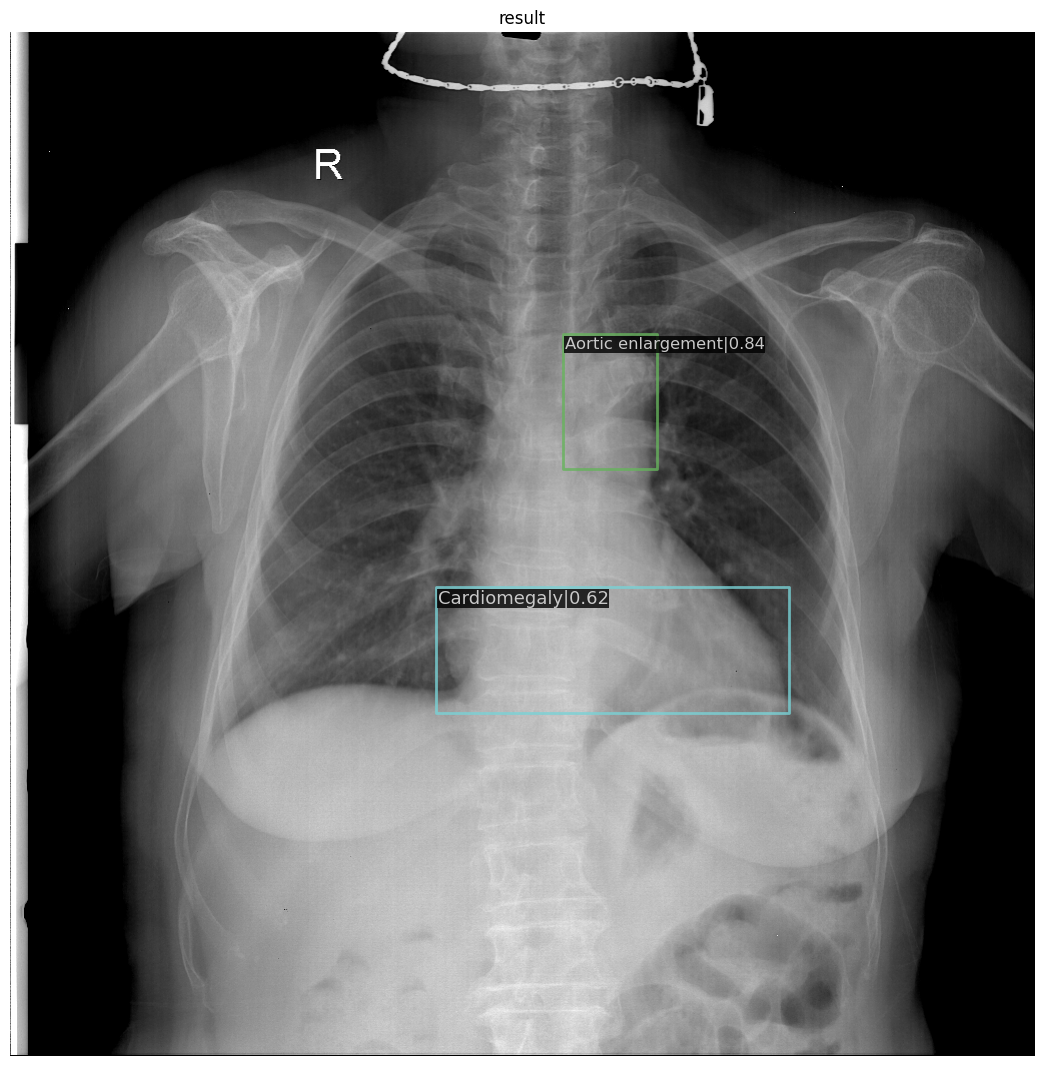

In [36]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


In [37]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

(14, (9, 5), (1, 5), (4, 5), (6, 5), (1, 5))

In [38]:
test_df= pd.read_csv('/home/ubuntu/mmdet1024/input/test.csv')

In [39]:
# test FILE real 해상도
test_df

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376
...,...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,2642,3170
2996,c97e54a78bab9c05ce2e04fe6c284bcd,3072,3072
2997,33218cf183c1224a74ccfb514e827e15,2336,2836
2998,04b700c4815f088728db9f093c739707,2484,3064


In [41]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [42]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.5 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
        
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)

    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        
        # 1024절대좌표
        boxes = boxes[indexes]


        # 1024 상대좌표
        boxes_relative=boxes/1024.0
        
        # test 해상도 width, height
        test = test_df[test_df['image_id'] == image_id]
        test_width = float(test['width'])
        test_height = float(test['height'])

        # xmin ymin xmax ymax
        # x * width
        # y * height
        for i,box in enumerate(boxes_relative):
            box[0] = float(box[0] * test_width)
            box[1] = float(box[1] * test_height) 
            box[2] = float(box[2] * test_width)
            box[3] = float(box[3] * test_height)

        # 최종 좌표
        boxes = boxes_relative
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [43]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

(3000, 2)

In [44]:
submission.head()

,image_id,PredictionString
0,ef7f329f4e29124e1d3bfec2b974f83c,0 0.9692 1093.9254150390625 729.5294189453125 ...
1,ea1d58be10d8b14394ad4147c5fbb60e,0 0.9612 1118.966796875 879.2134399414062 1387...
2,9c84001b9cecc492efc1d459c8b18a85,14 1.0 0 0 1 1
3,b1191a037edd92e49073961f2762a013,0 0.9227 1000.5396118164062 680.6459350585938 ...
4,163c884cba35d5d5ca50b7b8ea36a1fa,0 0.5504 827.5780029296875 602.5220336914062 1...


In [47]:
submission.to_csv(f'/home/ubuntu/mmdet1024/output/model_retina/mmdedtection_retina_aws_1_{EPOCHS}.csv', index=False)